This notebook plots the online error rate curve in the paper.
You need to download the (data)[] to run this notebook.

In [6]:
import os
from glob import glob
import numpy as np
import scipy
from edit_distance import SequenceMatcher
import matplotlib.pyplot as plt

In [24]:
def smooth(x,window_len=11,window='flat'):
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2-1):-(window_len//2)]

/tmp/ipykernel_25533/96804720.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([int(x) for x in axs[0].get_xticks()], fontsize=14)
/tmp/ipykernel_25533/96804720.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([f'{int(x*100)}' for x in axs[0].get_yticks()], fontsize=14)
/tmp/ipykernel_25533/96804720.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([int(x) for x in axs[1].get_xticks()], fontsize=14)
/tmp/ipykernel_25533/96804720.py:102: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels([f'{int(x*100)}' for x in axs[1].get_yticks()], fontsize=14)


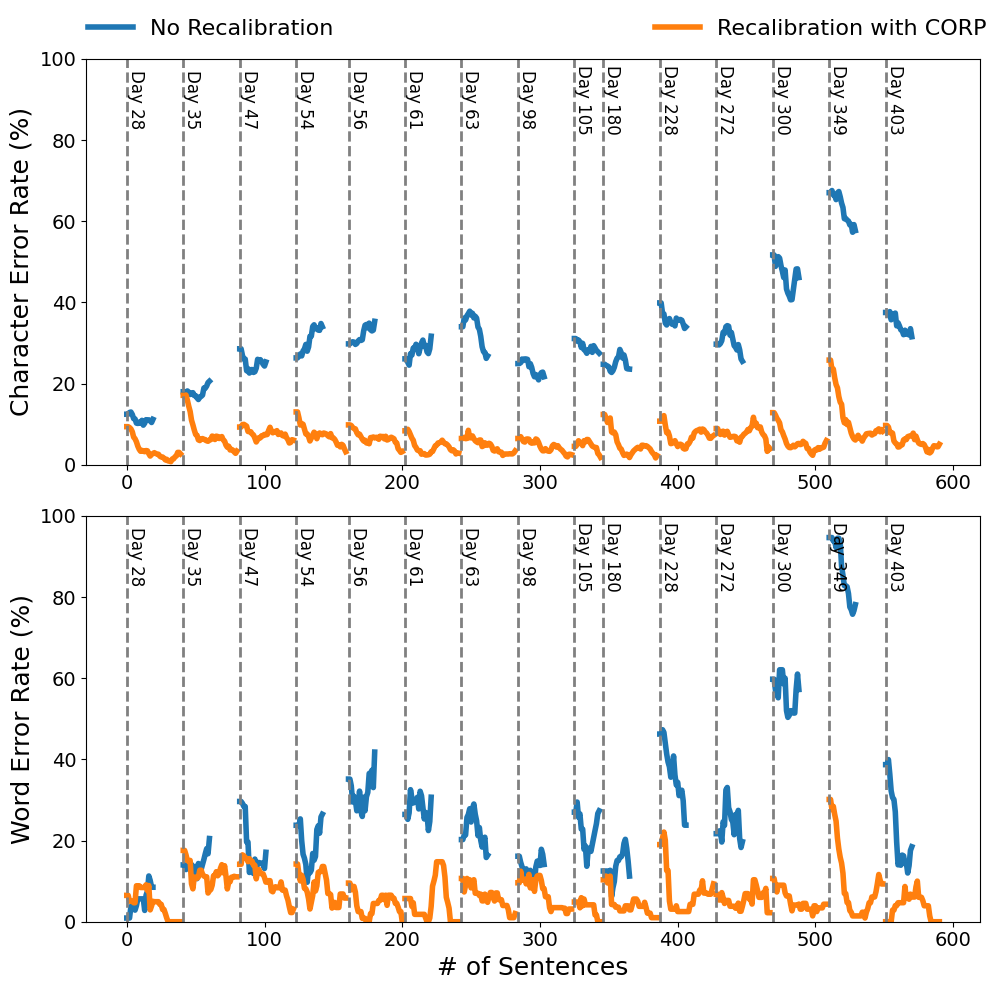

In [43]:
# Change this to the path to the CORP data release
data_dir = '/oak/stanford/groups/henderj/stfan/data/CORP_data_release/online_evaluation_data/'

def get_cer(gt, pred):
    gt = [l for l in gt]
    pred = [l for l in pred]
    matcher = SequenceMatcher(a=gt, b=pred) 
    return matcher.distance() / len(gt)

def get_wer(gt, pred):
    gt = gt.split('>')
    pred = pred.split('>')
    matcher = SequenceMatcher(a=gt, b=pred) 
    return matcher.distance() / len(gt)


# Recalibration blocks
mat_files = glob(os.path.join(data_dir, 'recalibration', 'mat', '*.mat'))
mat_files.sort()

recal_xs = []
recal_cers = []
recal_wers = []
session_start_idx = []
for i, mat_file in enumerate(mat_files):
    data = scipy.io.loadmat(mat_file)
    session = os.path.basename(mat_file)[:-4]
    gts = data['sentences'][0]
    preds = data['rnn_decoded'][0]
    session_start_idx.append(len(recal_cers))
    cers = []
    for j, (gt, pred) in enumerate(zip(gts, preds)):
        recal_xs.append(session_start_idx[i] + j)
        cers.append(get_cer(gt[0], pred[0]))
    cers = smooth(np.array(cers), window_len=10)
    recal_cers.extend(cers)
    recal_xs.append(session_start_idx[i] + len(gts))
    recal_cers.append(np.nan)  # Add nan so it does not smooth across sessions

    preds = data['lm_decoded'][0]
    wers = []
    for j, (gt, pred) in enumerate(zip(gts, preds)):
        wers.append(get_wer(gt[0], pred[0]))
    wers = smooth(np.array(wers), window_len=10)
    recal_wers.extend(wers)
    recal_wers.append(np.nan)  # Add nan so it does not smooth across sessions
session_start_idx.append(len(recal_cers))

    
# No recalibration blocks
mat_files = glob(os.path.join(data_dir, 'no_recalibration', 'mat', '*.mat'))
mat_files.sort()

no_recal_xs = []
no_recal_cers = []
no_recal_wers = []
for i, mat_file in enumerate(mat_files):
    data = scipy.io.loadmat(mat_file)
    session = os.path.basename(mat_file)[:-4]
    gts = data['sentences'][0]
    preds = data['rnn_decoded'][0]
    cers = []
    wers = []
    for j, (gt, pred) in enumerate(zip(gts, preds)):
        no_recal_xs.append(session_start_idx[i] + j)
        cers.append(get_cer(gt[0], pred[0]))
    cers = smooth(np.array(cers), window_len=10)
    no_recal_cers.extend(cers)
    no_recal_xs.append(session_start_idx[i] + len(gts))
    no_recal_cers.append(np.nan)  # Add nan so it does not smooth across sessions

    preds = data['lm_decoded'][0]
    wers = []
    for j, (gt, pred) in enumerate(zip(gts, preds)):
        wers.append(get_wer(gt[0], pred[0]))
    wers = smooth(np.array(wers), window_len=10)
    no_recal_wers.extend(wers)
    no_recal_wers.append(np.nan)  # Add nan so it does not smooth across sessions

 
# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
xs = np.arange(len(recal_cers))
axs[0].plot(no_recal_xs, no_recal_cers, linewidth=4)
axs[0].plot(recal_xs, recal_cers, linewidth=4)
axs[0].set_xticklabels([int(x) for x in axs[0].get_xticks()], fontsize=14) 
axs[0].set_ylim([0.0, 1.0])
axs[0].set_yticklabels([f'{int(x*100)}' for x in axs[0].get_yticks()], fontsize=14) 
axs[0].set_ylabel('Character Error Rate (%)', fontsize=18)

xs = session_start_idx
days = [28, 35, 47, 54, 56, 61, 63, 98, 105, 180, 228, 272, 300, 349, 403]
for i , (x, d) in enumerate(zip(xs[:-1], days)):
    axs[0].axvline(x=x, color='gray', ls='--', linewidth=2)
    axs[0].text(x, 0.9, "Day %d" % d, rotation=-90, verticalalignment='center', fontsize=12)
axs[0].legend(labels=['No Recalibration', 'Recalibration with CORP'], loc='lower left', mode='expand', ncol=2,
           bbox_to_anchor=(-0.02, 1.0, 1.05, 0.), frameon=False, fontsize=16)

axs[1].plot(no_recal_xs, no_recal_wers, linewidth=4)
axs[1].plot(recal_xs, recal_wers, linewidth=4)
axs[1].set_xticklabels([int(x) for x in axs[1].get_xticks()], fontsize=14) 
axs[1].set_ylim([0.0, 1.0])
axs[1].set_yticklabels([f'{int(x*100)}' for x in axs[1].get_yticks()], fontsize=14) 
axs[1].set_xlabel('# of Sentences', fontsize=18)
axs[1].set_ylabel('Word Error Rate (%)', fontsize=18)

days = [28, 35, 47, 54, 56, 61, 63, 98, 105, 180, 228, 272, 300, 349, 403]
for i , (x, d) in enumerate(zip(xs[:-1], days)):
    axs[1].axvline(x=x, color='gray', ls='--', linewidth=2)
    axs[1].text(x, 0.9, "Day %d" % d, rotation=-90, verticalalignment='center', fontsize=12)


plt.tight_layout()
plt.show()

In [16]:
kkkgts[0][0].split()



['at>least>she>never>knew>what>the>bottom>was>like~']